In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.animation
import yaml
import cv2
from scipy.spatial.transform import Rotation
from matplotlib.patches import Rectangle
from tqdm import tqdm


sys.path.append('/home/schiavazza/code/hpe/hpe-core/datasets/')

from vicon_processing.src.projection import ProjectionHelper
from vicon_processing.src.data_helpers import DvsLabeler, DvsHelper, C3dHelper
from vicon_processing.src import vis_utils, utils


In [2]:

# import the DVS data
dvs_file_path = '/home/schiavazza/data/hpe/vicon_recordings/stefano/2'
dvs_helper = DvsHelper(dvs_file_path)


In [68]:

# load c3d vicon data
c3d_file_path = '/home/schiavazza/data/hpe/vicon_recordings/EDPR_hpe/processed-tests/P002/session/stefano2.c3d'
c3d_helper = C3dHelper(c3d_file_path)
print(c3d_helper.reader.point_labels)


['camera:top                    ' 'camera:side                   '
 'camera:front                  ' 'P001:LFHD                     '
 'P001:RFHD                     ' 'P001:LBHD                     '
 'P001:RBHD                     ' 'P001:C7                       '
 'P001:T10                      ' 'P001:CLAV                     '
 'P001:STRN                     ' 'P001:RBAK                     '
 'P001:LSHO                     ' 'P001:LUPA                     '
 'P001:LELB                     ' 'P001:LFRM                     '
 'P001:LWRA                     ' 'P001:LWRB                     '
 'P001:LFIN                     ' 'P001:RSHO                     '
 'P001:RUPA                     ' 'P001:RELB                     '
 'P001:RFRM                     ' 'P001:RWRA                     '
 'P001:RWRB                     ' 'P001:RFIN                     '
 'P001:LASI                     ' 'P001:RASI                     '
 'P001:LPSI                     ' 'P001:RPSI                  

In [84]:
labels = c3d_helper.reader.point_labels[-15:-3]
print(labels)

['P001:LHJC                     ' 'P001:RHJC                     '
 'P001:LKJC                     ' 'P001:RKJC                     '
 'P001:LAJC                     ' 'P001:RAJC                     '
 'P001:LSJC                     ' 'P001:RSJC                     '
 'P001:LEJC                     ' 'P001:REJC                     '
 'P001:LWJC                     ' 'P001:RWJC                     ']


In [74]:

# import transformation
T = np.load('../data/transformation.npy')


In [6]:

# reading events
print('Loading events... (may take a while)')
dvs_helper.read_events()


Loading events... (may take a while)
importIitYarp trying path: /home/schiavazza/data/hpe/vicon_recordings/stefano/2
importIitYarp trying path: /home/schiavazza/data/hpe/vicon_recordings/stefano/2/ATIS


100%|██████████| 62810/62810 [03:37<00:00, 289.43it/s]


Examining info.log: /home/schiavazza/data/hpe/vicon_recordings/stefano/2/ATIS/info.log


{'ts': array([-1.6907109 , -1.6907109 , -1.6907109 , ..., 26.28953899,
        26.28953899, 26.28953899]),
 'x': array([181,  93, 506, ..., 203, 186, 201], dtype=uint16),
 'y': array([273, 276, 280, ..., 117, 117, 117], dtype=uint16),
 'pol': array([ True,  True, False, ..., False, False, False]),
 'tsOffset': -1686759523.412273}

In [75]:

c3d_helper.find_start_time()

proj_helper = ProjectionHelper()
proj_helper.import_camera_calbration('../data/temp_calib.txt');



In [87]:

labels = c3d_helper.reader.point_labels[-15:-3]
labels = [l.strip() for l in labels]

with open('../data/labels.yml', 'w') as yaml_file:
    yaml.dump(labels, yaml_file)

In [ ]:

def get_projected_points(frame_id):
    T_markers = c3d_helper.marker_T_at_frame_vector(frame_id)
    points_dict = c3d_helper.get_points_dict(frame_id)
    filtered_points = c3d_helper.filter_dict_labels(points_dict, labels)

    v_points = c3d_helper.points_dict_to_array(filtered_points)
    v_points = v_points[:, :4]
    v_points[:, -1] = 1
    
    projected_points = proj_helper.project_to_frame(
        proj_helper.transform_points(
            v_points, T @ T_markers
            )
        )
    
    return projected_points

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (640, 480))

for i in tqdm(range(c3d_helper.reader.first_frame, int(c3d_helper.reader.frame_count), 3)):
    projected_points = get_projected_points(i);
    
    frame = np.ones((480, 640, 3), dtype=np.uint8) * 100

    ts_start = c3d_helper.frame_times[i]
    frame = utils.extract_frame(dvs_helper.events, ts_start, ts_start + 0.01, (480, 640, 3))

    frame = vis_utils.plot_2d_points(frame, projected_points)
    out.write(frame.astype(np.uint8))
out.release()

In [9]:
c3d_helper.reader.first_frame

1

In [10]:
%matplotlib inline

c3d_helper.find_start_time()

array([1.52])

In [11]:
dvs_helper.read_annotation(dvs_helper.file_path)

1.692438

In [12]:
c3d_helper.frame_times

array([-1.52      , -1.50999648, -1.49999296, ..., 26.87999296,
       26.88999648, 26.9       ])

In [60]:
vicon_labeled_frames = np.arange(1000, 2050)
labels = [
    'camera:side'
]

# vicon_labeled_frames = c3d_helper.get_frame_time(labels_times)
print(c3d_helper.frame_times)
vicon_points = c3d_helper.get_vicon_points(vicon_labeled_frames, labels)

[-1.52       -1.50999648 -1.49999296 ... 26.87999296 26.88999648
 26.9       ]


In [61]:
vicon_points = c3d_helper.points_dict_to_array(vicon_points)

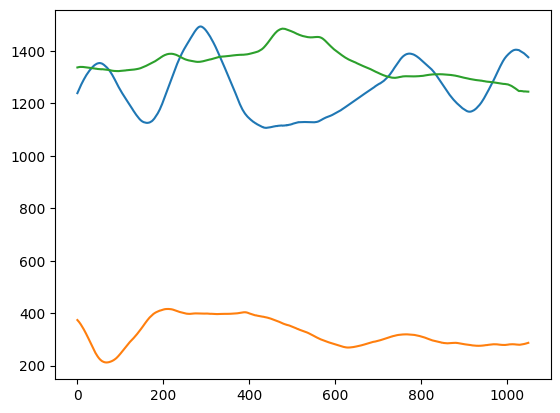

In [62]:
plt.plot(vicon_points[:, :3])

[-1.52       -1.50999648 -1.49999296 ... 26.87999296 26.88999648
 26.9       ]


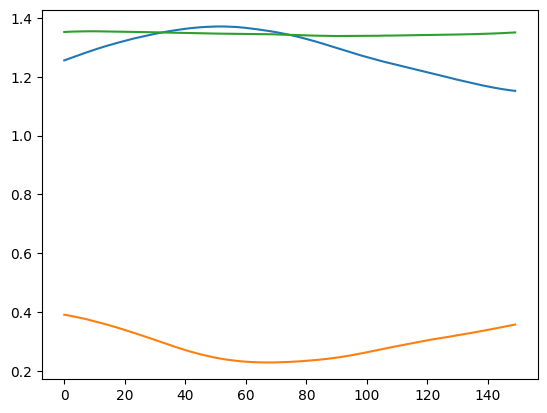

In [59]:
# vicon_labeled_frames = np.arange(1000, 1500)
labels = [
    'camera:USERMO1'
]

# vicon_labeled_frames = c3d_helper.get_frame_time(labels_times)
print(c3d_helper.frame_times)
vicon_points = c3d_helper.get_vicon_points(vicon_labeled_frames, labels)
vicon_points = c3d_helper.points_dict_to_array(vicon_points)
plt.plot(vicon_points[:, :3])